# Smart Web Crawling: A Dynamic and Controllable Approach to Web

Crawling

Crawling Kenyan Legal Documents with Python

Kabui, Charles  
2025-08-03

 *** 
[Read at <u>**ToKnow**</u>.ai](https://toknow.ai/posts/check/smart-web-crawling-dynamic-and-controllable-approach-to-web-crawling/index.html) -- [Download as Notebook](https://toknow.ai/posts/check/smart-web-crawling-dynamic-and-controllable-approach-to-web-crawling/index.output.ipynb) -- [Download as PDF](https://toknow.ai/posts/check/smart-web-crawling-dynamic-and-controllable-approach-to-web-crawling/index.pdf)
 *** 

<figure>
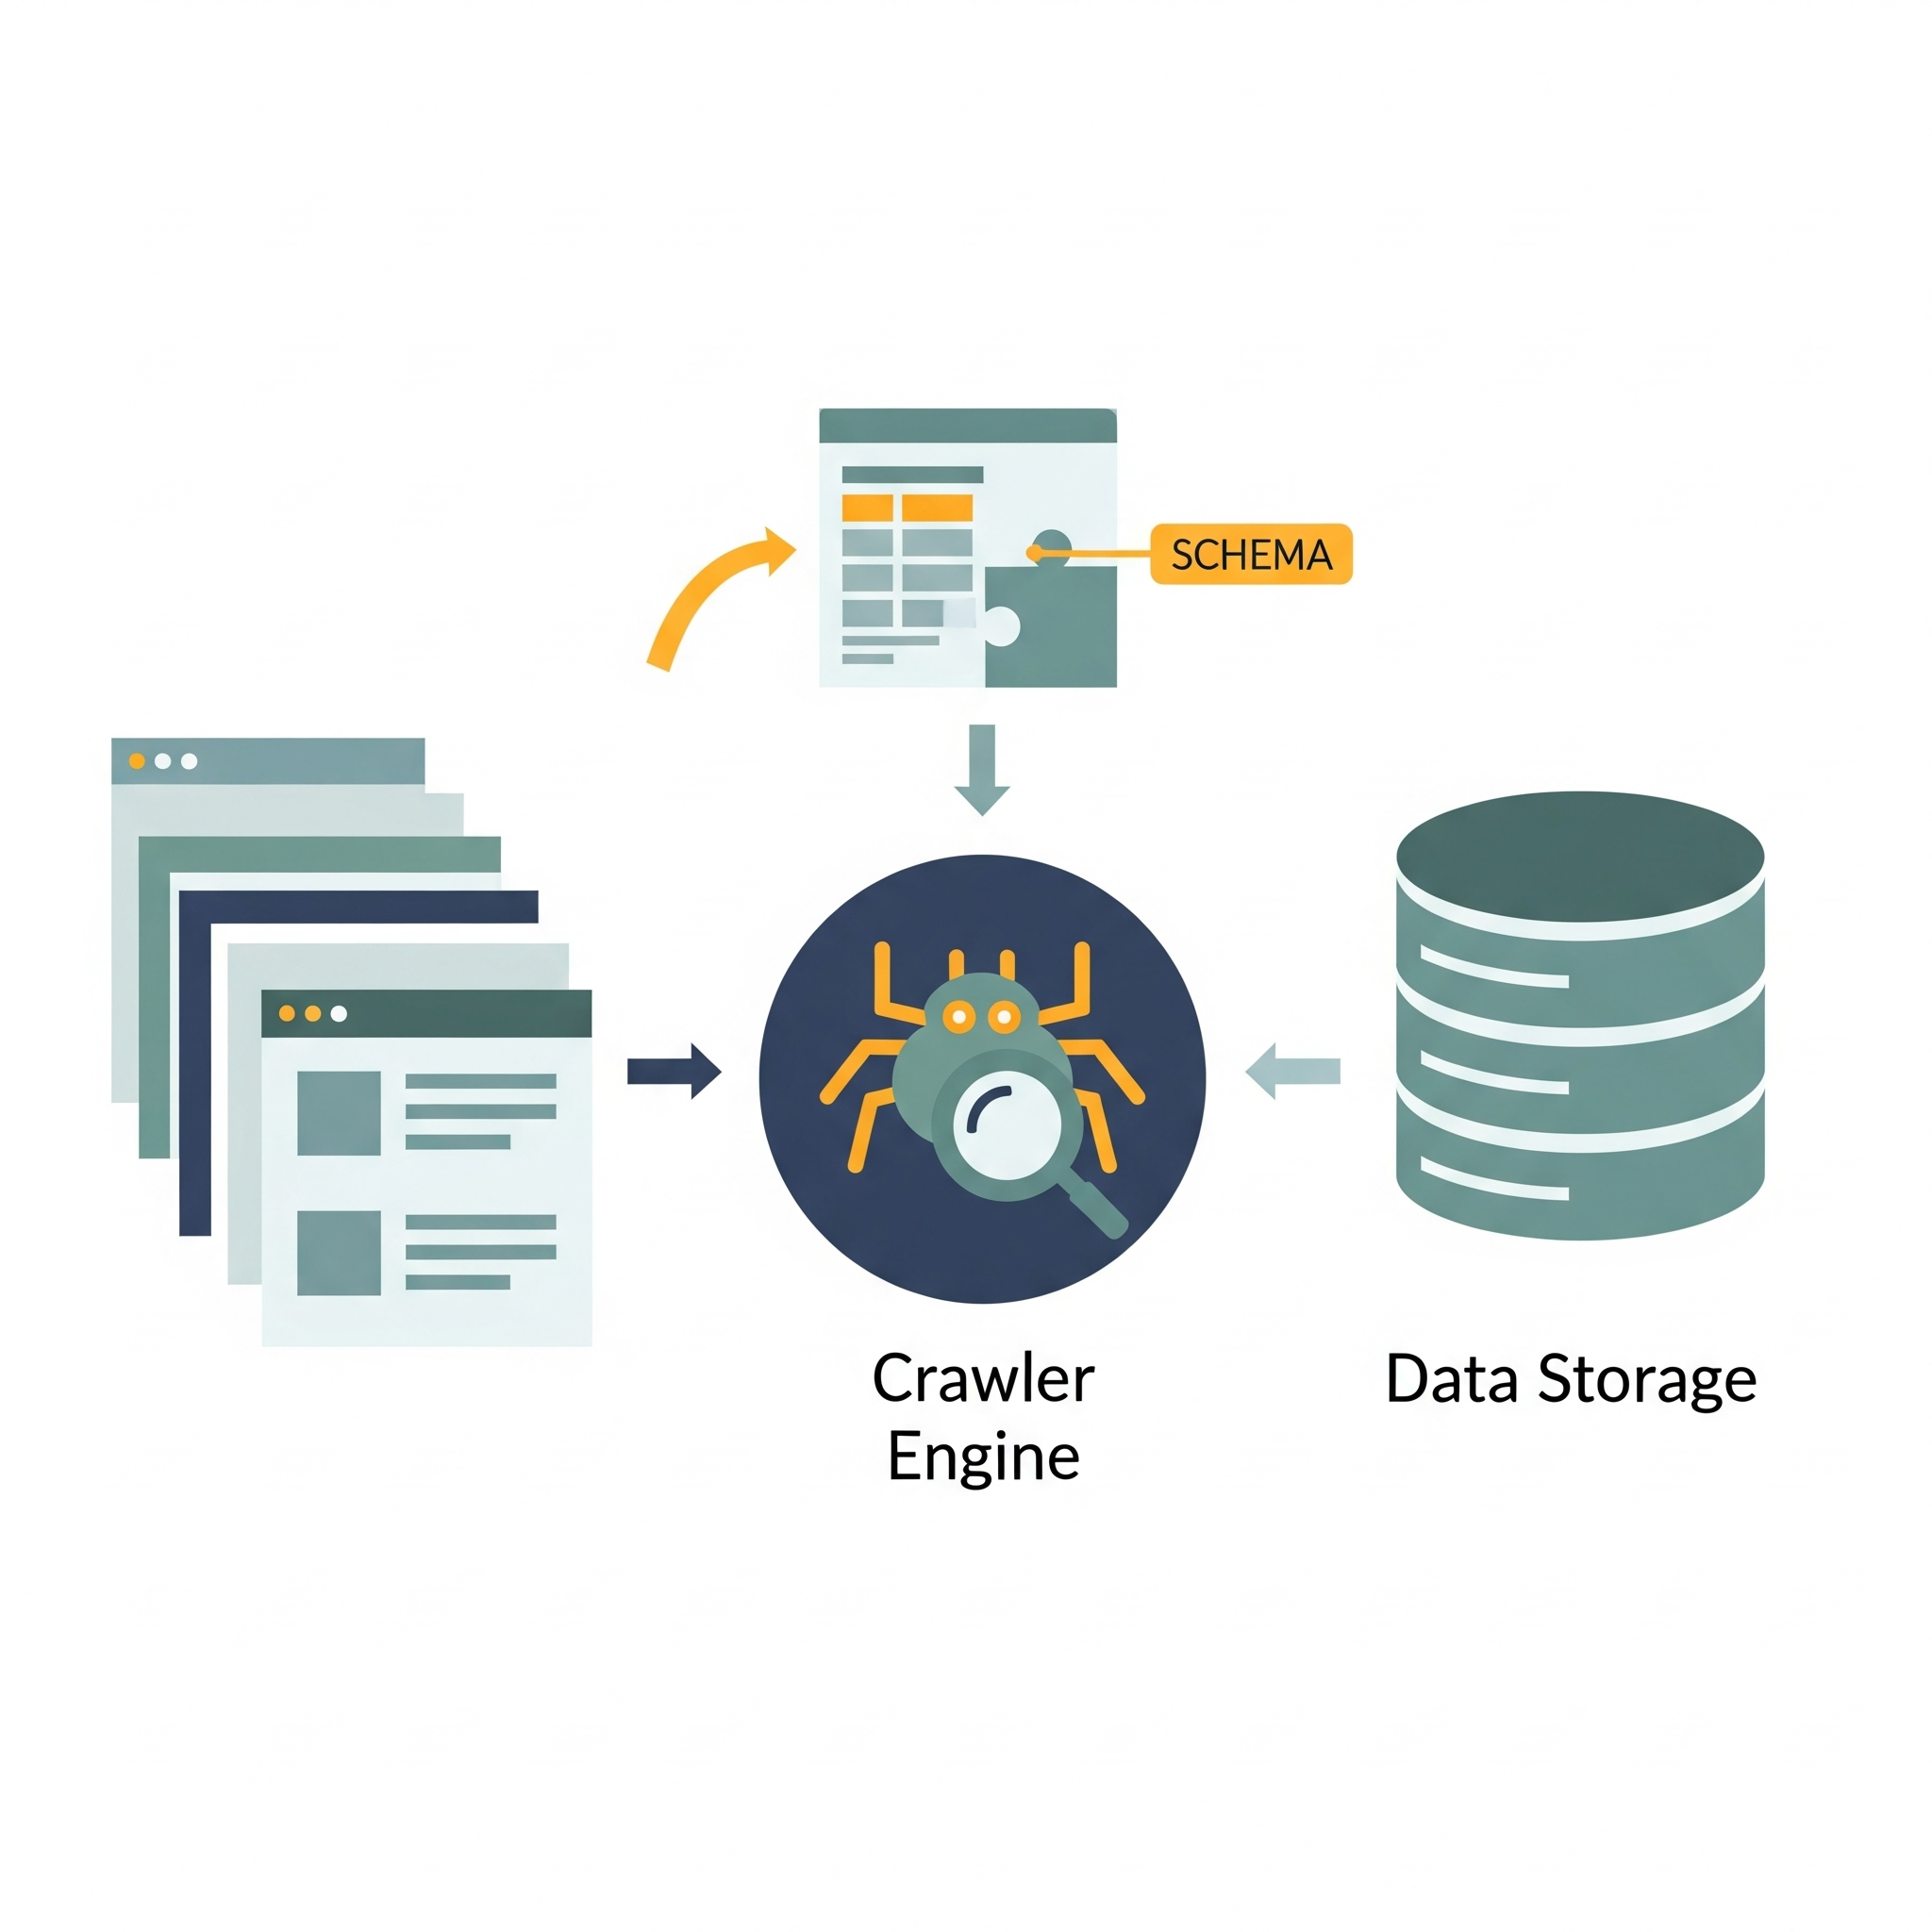
<figcaption aria-hidden="true">Smart Web Crawling: A Dynamic and
Controllable Approach to Web Crawling</figcaption>
</figure>

## The Challenge: Precision Over Scale

While enterprise crawling solutions like
[Scrapy](https://www.scrapy.org/) or [Apache
Nutch](https://nutch.apache.org/) excel at massive-scale data
extraction, small scale crawling need something different: **controlled,
schema-driven crawling with surgical precision**.

This approach isn’t about crawling millions of pages per hour. It’s
about crawling the *right* pages, in the *right* way, with complete
control over the process.

**Schema-Based Crawling** allows you to define how your crawler
interacts with different websites, making it adaptable to various site
structures and behaviors.

Each target site is treated as a unique ecosystem with its own rules.

Here is an example of a schema for crawling \<kenyalaw.org\>:

``` js
const schemas = [
    {
      prepare_page_expression: () => {
        return new Promise((resolve) => setTimeout(resolve, 10 * 1000));
      },
      locations: [
        { regex: ".*kenyalaw.org.*", examples: ["https://kenyalaw.org/"] },
      ],
      ignorePages: [
        {
          regex: "^(?!.*kenyalaw\\.org).*",
          examples: ["https://www.facebook.com/MyKenyaLaw"],
        },
      ],
    },
  ];
```

This schema tells our crawler: - **Where to operate:** `locations` field
specifies the domains/locations the crawler is permitted to explore,
only on \<kenyalaw.org\> domains - **What to ignore:** `ignorePages`
prevents the crawler from visiting undesirable links, such as social
media pages - **How to prepare:** `prepare_page_expression` field allows
for custom JavaScript to execute before link extraction

## State Management with SQLite

A persistent database is crucial. This approach uses an SQLite database
to store and manage the discovered links and their status.

``` python
class Status(Enum):
    DOWNLOADED = "downloaded"
    CRAWL = "crawl"
    CRAWLED = "crawled"
```

Each URL has a status, retry count, and timestamps. This enables: -
**Resumable crawling:** Stop and restart without losing progress -
**Retry logic:** Handle temporary failures gracefully - **Analytics:**
Track crawling progress and patterns

## Dynamic JavaScript Execution

The system generates JavaScript that: - Validates each domain against
schema rules - Executes custom preparation code - Extracts and filters
links based on ignore patterns - Returns clean, deduplicated URLs

``` javascript
const isLocationAllowed = schema.locations.some((domain) =>
  new RegExp(domain.regex).test(location.href)
);

if (isLocationAllowed) {
  if (schema.prepare_page_expression) {
    await Promise.resolve(schema.prepare_page_expression());
  }
  // Extract links...
}
```

## Real-World Application: KenyaLaw.org

Let’s see this in action with a legal database crawler:

### The Problem

KenyaLaw.org contains thousands of legal documents across multiple
formats: - Case law with metadata - PDF exports - XML structured data -
Search result pages

### The Solution

Our schema-based approach:

1.  **Discovers** all case law URLs through search pages
2.  **Ignores** direct external links, eg: social media links
3.  **Handles** JavaScript-heavy search interfaces
4.  **Tracks** progress in SQLite for reliability

``` python
# Start crawling from advanced search
await crawl_and_save("https://kenyalaw.org/caselaw/cases/advanced_search/")

# System automatically discovers:
# - Individual case pages
# - Additional search result pages  
# - Related legal document links
# While ignoring export endpoints
```

## Google Colab Integration

One unique advantage: this runs beautifully in Google Colab. Mount your
Google Drive, point the database there, and you have persistent,
resumable crawling with zero local setup:

``` python
from google.colab import drive
drive.mount("/content/drive")
database_path_str = "/content/drive/MyDrive/legal_crawl/database.db"
```

Your crawling state persists across Colab sessions, and you can analyze
results directly in notebooks.

## Controlled Resource Management

The system includes smart resource management:

``` python
refresh_browser_tabs = 50  # Restart browser every 50 tabs
crawl_count = 10          # Process 10 URLs per batch
```

This prevents memory leaks and browser crashes during long-running
crawls while maintaining reasonable throughput.

## When to Use This Approach

**Perfect for:** - Legal document databases - Academic research sites -
News archives with complex navigation - Sites requiring authentication
or session management - JavaScript-heavy applications - Projects needing
precise control over crawling behavior

**Not suitable for:** - High-volume, simple website crawling - Basic
e-commerce product scraping - Sites with robust APIs - When speed trumps
control

## Small Scale Crawling Advantage

This approach shines when you need:

-   **Precision over speed:** Quality links, not quantity
-   **Flexibility:** Easy schema updates for new sites
-   **Observability:** Full visibility into crawling progress
-   **Resumability:** Handle interruptions gracefully
-   **Cost control:** Run on free Google Colab instead of expensive
    cloud crawling services

## Code

In [1]:
# Path to the SQLite database file
database_path_str = "./_database.db"

# Number of browser tabs to open before refreshing the browser (prevents memory leaks)
refresh_browser_tabs = 50

# Number of URLs to process per crawling batch
crawl_count = 10

### Colab Setup

If you are running this in Google Colab, uncomment and run the following
code to set up the environment:

In [2]:
# # Install required Python packages and Playwright browser binaries
# !pip install playwright peewee jsbeautifier
# !playwright install

# # Mount Google Drive to access persistent storage in Colab
# from google.colab import drive
# drive.mount("/content/drive")

# # Set the database path to a location on Google Drive for persistence
# database_path_str = "/content/drive/MyDrive/legal_crawl/database.db"

### Import Required Libraries

In [3]:
import asyncio
import json
import shutil
from datetime import datetime, timezone
from enum import Enum
from pathlib import Path
from typing import Any, Callable, Coroutine, List, Literal, Tuple, TypedDict

import jsbeautifier
import peewee
from playwright.async_api import (
    Browser,
    Page,
    Playwright,
    async_playwright,
)

### Browser Functions

In [4]:
async def get_browser_async(
    p: Playwright, executable_path: str = None, *, headless=True, incognito=False
) -> Browser:
    """
    Launches a Chromium browser instance using Playwright.

    Args:
        p (Playwright): The Playwright instance.
        executable_path (str, optional): Path to the Chromium/Chrome executable.
            If None, tries to auto-detect.
        headless (bool, optional): Whether to run browser in headless mode. Default is True.
        incognito (bool, optional): Whether to launch browser in incognito mode. Default is False.

    Returns:
        Browser: The launched Playwright browser instance.
    """
    executable_path = (
        executable_path
        or shutil.which("google-chrome")
        or shutil.which("chromium-browser")
        or shutil.which("chromium")
        or None
    )

    browser = await p.chromium.launch(
        headless=headless,
        executable_path=executable_path,
        args=["--disable-web-security"] + (["--incognito"] if incognito else []),
    )
    return browser


async def get_browser_page_async(
    executable_path: str = None,
    width: int = 0,
    height: int = 0,
    *,
    playwright: Playwright = None,
    headless: bool = True,
    incognito=False,
    refresh_browser_tabs: int = None
) -> tuple[Page, Callable[[], Coroutine[Any, Any, None]]]:
    """
    Returns a factory for new Playwright pages and a cleanup function.

    Args:
        executable_path (str, optional): Path to the Chromium/Chrome executable.
        width (int, optional): Viewport width for new pages. If 0, uses default.
        height (int, optional): Viewport height for new pages. If 0, uses default.
        playwright (Playwright, optional): Playwright instance. If None, starts a new one.
        headless (bool, optional): Whether to run browser in headless mode. Default is True.
        incognito (bool, optional): Whether to launch browser in incognito mode. Default is False.
        refresh_browser_tabs (int, optional): Number of tabs to open before refreshing the browser.

    Returns:
        tuple: (new_page function, close_playwright function)
            - new_page(): Coroutine that returns a new Playwright Page.
            - close_playwright(): Coroutine to close browser and Playwright resources.
    """
    playwright = await async_playwright().start()
    browser = None
    context = None
    tabs_created = 0

    async def new_page() -> Page:
        nonlocal browser
        nonlocal context
        if (
            browser == None
            or context == None
            or (refresh_browser_tabs and tabs_created > refresh_browser_tabs)
        ):
            if context:
                await context.close()
            if browser:
                await browser.close()
            browser = await get_browser_async(
                playwright, executable_path, headless=headless, incognito=incognito
            )
            context = await browser.new_context(
                ignore_https_errors=True, bypass_csp=True, accept_downloads=False
            )

        page = await context.new_page()
        viewport = {
            "width": width or page.viewport_size["width"],
            "height": height or page.viewport_size["height"],
        }
        await page.set_viewport_size(viewport_size=viewport)
        return page

    async def close_playwright():
        """
        Closes the browser context, browser, and stops Playwright.
        """
        await context.close()  # Close the browser context
        await browser.close()  # Close the browser
        await playwright.stop()  # Stop Playwright

    return new_page, close_playwright

### Sqlite Database Manager

In [5]:
class Status(Enum):
    """Enumeration for possible link statuses in the database."""

    DOWNLOADED = "downloaded"
    CRAWL = "crawl"
    CRAWLED = "crawled"


class DatabaseManager:
    """
    Manages a SQLite database of links with status, count, and timestamps.
    """

    def __init__(self, db_name: str):
        """Initialize database and Link model."""
        self.db = peewee.SqliteDatabase(db_name)

        class Link(peewee.Model):
            link = peewee.CharField(primary_key=True)
            status = peewee.CharField(choices=[s.value for s in Status])
            count = peewee.IntegerField(default=0)
            created_at = peewee.DateTimeField(
                default=lambda: datetime.now(timezone.utc)
            )
            updated_at = peewee.DateTimeField(
                default=lambda: datetime.now(timezone.utc)
            )

            class Meta:
                database = self.db

            def save(self, *args, **kwargs):
                self.updated_at = datetime.now(timezone.utc)
                return super().save(*args, **kwargs)

        self.Link = Link
        self.db.create_tables([self.Link])

    def reload_connection(self) -> bool:
        """Reload the database connection to recover from issues."""
        try:
            self.close()
            self.__init__(self.db.database)
            return True
        except Exception as e:
            print(f"Error reloading database connection: {e}")
            return False

    def create(self, link: str, status: Status, count: int = 0) -> bool:
        """Insert a new link with status and count."""
        try:
            self.Link.create(link=link, status=status.value, count=count)
            return True
        except peewee.IntegrityError:
            return False

    def read(
        self,
        link: str = None,
        status: Status = None,
        count: int = None,
        limit: int = None,
        count_expression: Literal["gt", "lt", "eq"] = "gt",
        include_timestamps: bool = False,
        randomize: bool = False,
    ) -> List[Tuple]:
        """
        Read links with optional filters and limit.
        Returns tuples of (link, status, count[, created_at, updated_at]).
        """
        query = self.Link.select()
        if link:
            query = query.where(self.Link.link == link)
        if status:
            query = query.where(self.Link.status == status.value)
        if count is not None:
            if count_expression == "gt":
                query = query.where(self.Link.count > count)
            elif count_expression == "lt":
                query = query.where(self.Link.count < count)
            else:
                query = query.where(self.Link.count == count)
        if randomize:
            query = query.order_by(peewee.fn.Random())
        if limit:
            query = query.limit(limit)
        if include_timestamps:
            return [
                (
                    l.link,
                    l.status,
                    l.count,
                    l.created_at.isoformat(),
                    l.updated_at.isoformat(),
                )
                for l in query
            ]
        else:
            return [(l.link, l.status, l.count) for l in query]

    def read_where(
        self,
        limit: int = None,
        include_timestamps: bool = False,
        randomize: bool = False,
        **filters,
    ) -> List[Tuple]:
        """
        Flexible read with keyword filters.
        Returns tuples of (link, status, count[, created_at, updated_at]).
        """
        query = self.Link.select()
        for field, value in filters.items():
            if field == "link":
                query = query.where(self.Link.link == value)
            elif field == "status":
                if isinstance(value, Status):
                    value = value.value
                query = query.where(self.Link.status == value)
            elif field == "link_contains":
                query = query.where(self.Link.link.contains(value))
            elif field == "link_startswith":
                query = query.where(self.Link.link.startswith(value))
            elif field == "count":
                query = query.where(self.Link.count == value)
            elif field == "count_gt":
                query = query.where(self.Link.count > value)
            elif field == "created_after":
                if isinstance(value, str):
                    value = datetime.fromisoformat(value.replace("Z", "+00:00"))
                query = query.where(self.Link.created_at > value)
            elif field == "created_before":
                if isinstance(value, str):
                    value = datetime.fromisoformat(value.replace("Z", "+00:00"))
                query = query.where(self.Link.created_at < value)
        if randomize:
            query = query.order_by(peewee.fn.Random())
        if limit:
            query = query.limit(limit)
        if include_timestamps:
            return [
                (
                    l.link,
                    l.status,
                    l.count,
                    l.created_at.isoformat(),
                    l.updated_at.isoformat(),
                )
                for l in query
            ]
        else:
            return [(l.link, l.status, l.count) for l in query]

    def update(self, link: str, status: Status = None, count: int = None) -> bool:
        """Update status and/or count for a link. Returns True if updated."""
        updates = {}
        if status:
            updates["status"] = status.value
        if count is not None:
            updates["count"] = count
        updates["updated_at"] = datetime.now(timezone.utc)
        if len(updates) == 1:
            return False
        query = self.Link.update(**updates).where(self.Link.link == link)
        return query.execute() > 0

    def increment_count(self, link: str) -> bool:
        """Increment the count for a link. Returns True if updated."""
        query = self.Link.update(
            count=self.Link.count + 1, updated_at=datetime.now(timezone.utc)
        ).where(self.Link.link == link)
        return query.execute() > 0

    def delete(self, link: str) -> bool:
        """Delete a link. Returns True if deleted."""
        return self.Link.delete().where(self.Link.link == link).execute() > 0

    def get_statistics(self) -> dict:
        """Return statistics: total, per-status, oldest/newest timestamps."""
        total_count = self.Link.select().count()
        status_counts = {}
        for status in Status:
            count = self.Link.select().where(self.Link.status == status.value).count()
            status_counts[status.value] = count
        oldest = self.Link.select().order_by(self.Link.created_at.asc()).first()
        newest = self.Link.select().order_by(self.Link.created_at.desc()).first()
        return {
            "total_links": total_count,
            "status_breakdown": status_counts,
            "oldest_entry": oldest.created_at if oldest else None,
            "newest_entry": newest.created_at if newest else None,
        }

    def close(self):
        """Close the database connection."""
        if not self.db.is_closed():
            self.db.close()

### Schema

In [6]:
class PagePattern(TypedDict):
    """
    Represents a pattern for matching or ignoring pages.
    - regex: Regular expression to match URLs.
    - examples: Example URLs matching the regex.
    """
    regex: str
    examples: List[str]

class Schema(TypedDict):
    """
    Defines crawling rules for a website.
    - prepare_page_expression: JavaScript code to run before extracting links.
    - locations: List of allowed page patterns.
    - ignorePages: List of patterns to ignore.
    """
    prepare_page_expression: str
    locations: List[PagePattern]
    ignorePages: List[PagePattern]

schemas: List[Schema] = [
    {
        "prepare_page_expression": "() => Promise.resolve()",
        "locations": [
            {"regex": ".*kenyalaw.org.*", "examples": ["https://kenyalaw.org/"]}
        ],
        "ignorePages": [
            {
                "regex": "^(?!.*kenyalaw\\.org).*",
                "examples": ["https://www.facebook.com/MyKenyaLaw"],
            },
        ],
    }
]

The following function serializes Python data structures into a string
suitable for JavaScript, treating string values of specified `raw_keys`
as raw code (not quoted).

In [7]:
def custom_serialize(data: Any, raw_keys: list[str] = None):
    """
    Recursively serializes Python data structures into a string
    suitable for JavaScript, treating string values of specified 'raw_keys'
    as raw code (not quoted).

    Args:
        data: The Python data structure (dict, list, str, int, float, bool, None)
              to be serialized.
        raw_keys: An optional list of strings representing keys whose string values
                  should be treated as raw JavaScript code and not quoted.
    """
    if raw_keys is None:
        raw_keys = []

    if isinstance(data, dict):
        # If it's a dictionary, serialize its keys and values
        items = []
        for k, v in data.items():
            # Keys are usually strings and should be quoted if not raw
            key_str = (
                json.dumps(k) if isinstance(k, str) else str(k)
            )  # Use json.dumps for keys too for consistency

            # Check if the current key is in the raw_keys list and its value is a string
            if k in raw_keys and isinstance(v, str):
                # If it's a raw key and a string, return the value directly without quoting
                items.append(f"{key_str}: {v}")
            else:
                # Otherwise, recursively serialize the value with the same raw_keys list
                items.append(f"{key_str}: {custom_serialize(v, raw_keys)}")
        return "{" + ", ".join(items) + "}"
    elif isinstance(data, list):
        # If it's a list, serialize each item recursively
        elements = [custom_serialize(item, raw_keys) for item in data]
        return "[" + ", ".join(elements) + "]"
    elif isinstance(data, str):
        # Regular strings need to be quoted using json.dumps to handle escaping
        return json.dumps(data)
    elif isinstance(data, (int, float, bool, type(None))):
        # Numbers, booleans, and None (null in JS) can be converted directly
        return (
            str(data).lower() if isinstance(data, bool) else str(data)
        )  # Convert Python True/False to JS true/false
    else:
        # Fallback for other unsupported types
        raise TypeError(f"Unsupported type for serialization: {type(data)}")

Generate the JavaScript code to evaluate the schemas and extract links:

In [8]:
def generate_evaluate_script(schemas: List[Schema]):
    schemas_str = custom_serialize(schemas, ["prepare_page_expression"])
    evaluate_script = (
        "async () => {\n"
        f"const schemas = {schemas_str}\n"
        """
        /** @type {string[]} */
        const errors = [];
        const generator = async function* () {
          try {
            for (const schema of schemas) {
              try {
                const isLocationAllowed = schema.locations.some((domain) =>
                  new RegExp(domain.regex).test(location.host + location.pathname)
                );
                if (isLocationAllowed) {
                  if (schema.prepare_page_expression) {
                    await Promise.resolve(schema.prepare_page_expression());
                  }

                  const $anchors = [...document.querySelectorAll("a")];
                  /**
                  * Validates string
                  * @param {HTMLAnchorElement} link
                  * @returns {string} the valid string
                  */
                  const validateLink = (link) => {
                    try {
                      if (link.href) {
                        const url = new URL(link.href);
                        const validProtocols = ["https:", "http:", "ftp:"];
                        const normalizedProtocol = url.protocol.toLowerCase();
                        if (validProtocols.includes(normalizedProtocol)) {
                          return link.href;
                        }
                      }
                    } catch (error) {
                      errors.push(error);
                    }
                    return "";
                  };
                  /**
                  * @param {string} link
                  * @returns {boolean}
                  */
                  const isIgnoreLink = (link) => {
                    return schema.ignorePages.some((ignorePage) => {
                      return new RegExp(ignorePage.regex).test(new URL(link).host);
                    });
                  };
                  const links = [
                    ...new Set($anchors.map(validateLink).filter((i) => !!i)),
                  ];

                  for (const link of links) {
                    try {
                      if (!isIgnoreLink(link)) {
                        yield link;
                      }
                    } catch (error) {
                      errors.push(error);
                    }
                  }
                }
              } catch (error) {
                errors.push(error);
              }
            }
          } catch (error) {
            errors.push(error);
          }
        };

        /** @type {string[]} */
        const links = [];
        for await (const item of generator()) {
          links.push(item);
        }
        return [links, errors];
      }
    """
    )
    return evaluate_script

print(jsbeautifier.beautify(generate_evaluate_script(schemas)))

async () => {
    const schemas = [{
        "prepare_page_expression": () => Promise.resolve(),
        "locations": [{
            "regex": ".*kenyalaw.org.*",
            "examples": ["https://kenyalaw.org/"]
        }],
        "ignorePages": [{
            "regex": "^(?!.*kenyalaw\\.org).*",
            "examples": ["https://www.facebook.com/MyKenyaLaw"]
        }]
    }]

    /** @type {string[]} */
    const errors = [];
    const generator = async function*() {
        try {
            for (const schema of schemas) {
                try {
                    const isLocationAllowed = schema.locations.some((domain) =>
                        new RegExp(domain.regex).test(location.host + location.pathname)
                    );
                    if (isLocationAllowed) {
                        if (schema.prepare_page_expression) {
                            await Promise.resolve(schema.prepare_page_expression());
                        }

                        const $anch

### Initialize the Crawler

In [9]:
# Ensure the database path exists
database_path = Path(database_path_str)
database_path.parent.mkdir(exist_ok=True)
# Initialize the database manager
database = DatabaseManager(database_path)

In [10]:
# Initialize Playwright page factory and cleanup function
new_page, close_playwright = await get_browser_page_async(
    refresh_browser_tabs=refresh_browser_tabs
)

async def crawl_and_save(link: str):
    """
    Crawls a single URL, extracts sub-links using the schema-based JS,
    saves new links to the database, and updates crawl status.
    Retries on error by incrementing the count.
    """
    try:
        page: Page = await new_page()
        await page.goto(link, wait_until="networkidle")

        sub_links, errors = await page.evaluate(generate_evaluate_script(schemas))
        if len(errors) > 0:
            print(errors)
        await page.close()
        added_count = 0
        for sub_link in sub_links:
            if database.create(sub_link, Status.CRAWL):
                added_count = added_count + 1

        database.update(link, Status.CRAWLED)
        if added_count > 0:
            print(f"Added {added_count}/{len(sub_links)} links from {link}")
    except Exception as e:
        print(e)
        database.increment_count(link)

In [11]:
async def crawl_and_dowload():
    """
    Recursively crawls up to `crawl_count` URLs with status=Status.CRAWL and count=0.
    For each batch:
      - Runs `crawl_and_save` concurrently on all selected records.
      - Reloads the database connection after each batch.
      - Continues until no more URLs to crawl.
    """
    records = database.read(
        limit=crawl_count,
        status=Status.CRAWL,
        count=0,
        count_expression="eq",
        randomize=True)
    if len(records) <= 0:
        print("Stopped...")
        return
    awaitables = [crawl_and_save(record[0]) for record in records]
    await asyncio.gather(*awaitables)
    await asyncio.sleep(1)
    database.reload_connection()
    await crawl_and_dowload()

In [ ]:
# # Initialize the crawling process
# await crawl_and_save("https://kenyalaw.org/caselaw/cases/advanced_search/")

Added 323/323 links from https://kenyalaw.org/caselaw/cases/advanced_search/

In [13]:
# Start the crawling process
await crawl_and_dowload()

Added 59/68 links from https://www.kenyalaw.org/kl/index.php?id=3158
Added 23/91 links from https://kenyalaw.org/caselaw/cases/advanced_search/?totaljudge=231&content=&courtname=&judgename=Antony%20Ombwayo&parties=&subject=&case_number=&judgeId=&courtId=&court=&date_to=&facet=1&date_from=
Added 19/83 links from https://kenyalaw.org/caselaw/cases/advanced_search/?totaljudge=249&content=&courtname=&judgename=Roselyne%20Ekirapa%20Aburili&parties=&subject=&case_number=&judgeId=&courtId=&court=&date_to=&facet=1&date_from=

In [15]:
# Print database statistics
database.get_statistics()

{'total_links': 424,
 'status_breakdown': {'downloaded': 0, 'crawl': 419, 'crawled': 5},
 'oldest_entry': '2025-08-04 15:57:56.569805+00:00',
 'newest_entry': '2025-08-04 15:58:15.964191+00:00'}

## Conclusion

The beauty of this system lies in its adaptability. Start with a simple
schema for your target site, define what to crawl and what to ignore,
and let the system discover the structure for you.

Whether you’re building a legal research tool, academic database, or
specialized content aggregator, schema-based crawling gives you the
surgical precision that enterprise tools can’t match, without the
enterprise complexity.

------------------------------------------------------------------------

After crawling, you can examine which links to process further. For
example, you can filter links that match cases or legislation such as
<http://kenyalaw.org/caselaw/cases/view/187364> and decide whether to
download and process the PDF
(<http://kenyalaw.org/caselaw/cases/export/187364/pdf>) or Word document
(<http://kenyalaw.org/caselaw/cases/export/187364/doc>) or XML
(<http://kenyalaw.org/caselaw/cases/export/187364/xml>).

------------------------------------------------------------------------

***Disclaimer:*** *For information only. Accuracy or completeness not
guaranteed. Illegal use prohibited. Not professional advice or
solicitation.* ***Read more:
[/terms-of-service](https://toknow.ai/terms-of-service)***